# Logistic Regression from an Adaline-like approach

In this notebook, we demonstrate how a gradient-descent-based Logistic Regression model can be implemented by making slight modifications to the Adaline gradient descent.

We will walk through reading and preparing the Iris dataset, implementing our Logistic Regression class, fitting it on a subset of Iris data for binary classification, and finally extending the same approach to multiple classes using a One-vs-All (OvA) scheme.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Loading the Iris dataset

In [2]:
# Reading-in the Iris data.
# We'll attempt to read it from the UCI Machine Learning Repository.
# If that fails, we revert to reading from a local path (if available). 

try:
    from urllib.error import HTTPError  # For completeness, in case not imported
    s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    print('From URL:', s)
    df = pd.read_csv(s, header=None, encoding='utf-8')

except HTTPError:
    s = 'iris.data'
    print('From local Iris path:', s)
    df = pd.read_csv(s, header=None, encoding='utf-8')

# The dataframe df now holds the Iris data, with the last column containing class labels.

From URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


### Implementing Logistic Regression with Gradient Descent

In [3]:
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.
    
    This class implements a logistic regression classifier that uses
    gradient descent to learn the parameters. It is closely related to 
    the Adaline implementation, with a different activation function 
    and loss calculation.
    
    Parameters
    ----------
    eta : float, default=0.01
        Learning rate (between 0.0 and 1.0)
    n_iter : int, default=50
        Number of passes over the training dataset.
    random_state : int, default=1
        Seed for random weight initialization.

    Attributes
    ----------
    w_ : 1D ndarray
        Weights after training.
    b_ : float
        Bias term after fitting.
    losses_ : list
        List of loss values at each epoch (cross-entropy here).
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors.
        y : array-like, shape = [n_samples]
            Target values (binary: 0 or 1).

        Returns
        -------
        self : object
            The fitted logistic regression model.
        """
        # For reproducibility
        rgen = np.random.RandomState(self.random_state)

        # Initialize weights to small random numbers
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # Initialize bias as zero
        self.b_ = 0.0

        self.losses_ = []

        for i in range(self.n_iter):
            # Compute net input
            net_input = self.net_input(X)

            # Pass net input through sigmoid activation
            output = self.activation(net_input)

            # Compute errors (difference between actual and predicted)
            errors = (y - output)

            # Update weights via gradient descent rule
            # The dot product yields sum of X_j * error_i, normalized by number of samples
            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]

            # Update bias
            self.b_ += self.eta * errors.mean()

            # Cross-entropy loss (Logistic Loss)
            # We add a small clip to avoid log(0) issues if needed.
            # Output is already clipped in self.activation, but this is an extra measure.
            output_clipped = np.clip(output, 1e-10, 1.0 - 1e-10)
            loss = -y.dot(np.log(output_clipped)) - (1 - y).dot(np.log(1 - output_clipped))
            loss /= X.shape[0]

            self.losses_.append(loss)

        return self

    def net_input(self, X):
        """Calculate net input (linear combination of weights and input)."""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation.
            We also apply np.clip(...) to prevent overflow in np.exp()."""
        z_clipped = np.clip(z, -250, 250)
        return 1. / (1. + np.exp(-z_clipped))

    def predict(self, X):
        """Return predicted class label (0 or 1) based on 0.5 threshold."""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

### Helper Function to Visualize Decision Boundaries

In [4]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    """
    Plots the decision regions for a 2D dataset (two chosen features).

    Parameters
    ----------
    X : array-like, shape = [n_samples, 2]
        Feature matrix for visualization (2 features).
    y : array-like, shape = [n_samples]
        Target labels.
    classifier : object
        A classifier with a .predict() method.
    resolution : float
        Step size in the mesh.

    """
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # find the min and max values for the two features (with a little extra margin)
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # create a 2D grid of points from these min/max values
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    # predict the label for each point in the grid
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    # create a contour plot for the decision boundaries
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot the data points by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

## EXAMPLE 1: Two classes, two features

Here, we will classify the Iris dataset's first 100 samples, which correspond to *Iris-setosa* and *Iris-versicolor*. We only take two features (for easier plotting).

In [5]:
# We'll select only the first 100 rows of Iris, as they correspond
# to Setosa and Versicolor classes.
# Then we create a binary label: 0 for setosa, 1 for versicolor.

y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# For the sake of easy plotting, we'll pick just two features:
# - Column 0: sepal length
# - Column 2: petal length
X = df.iloc[0:100, [0, 2]].values

#### Visualizing these two features

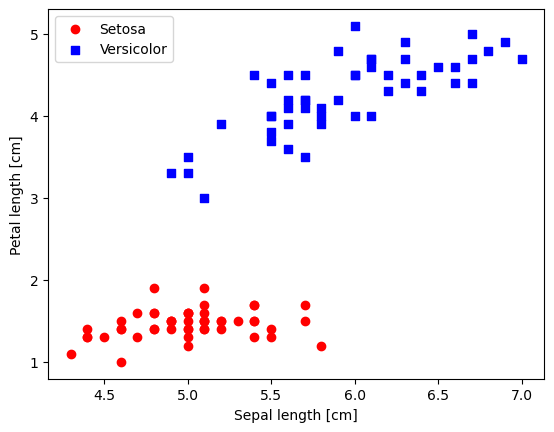

In [6]:
# Plot the data with Setosa in red, Versicolor in blue
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='s', label='Versicolor')

plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')

plt.show()

#### Fitting the Logistic Regression classifier on this dataset

In [7]:
# Instantiate our logistic regression (GD-based) with a higher learning rate.
lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)

# Fit the model on our two-feature data
lrgd.fit(X, y);

#### Visualizing the predictions vs. actual data

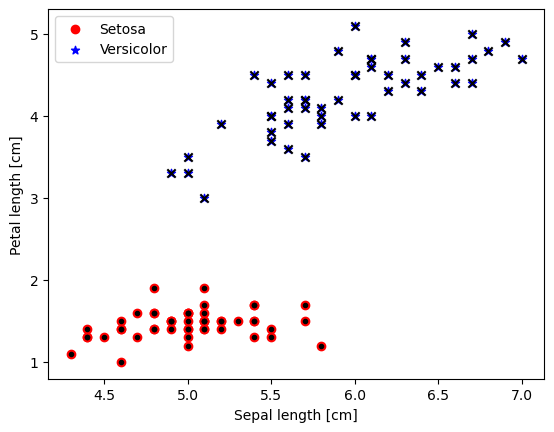

In [8]:
# Obtain predicted labels from the model
y_pred = lrgd.predict(X)

# Let's plot the data again, but also highlight predicted labels.
# We'll add small black markers: '.' for predicted class 0, 'x' for predicted class 1.

plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='*', label='Versicolor')

dict_iris = {0: '.', 1: 'x'}  # dictionary for predicted markers

for j in range(100):
    plt.scatter(X[j, 0], X[j, 1],
                color='black', marker=dict_iris[y_pred[j]])

plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

#### Plotting the decision boundary
Below, we use the `plot_decision_regions` helper to directly visualize the boundary that our logistic regression model has learned.

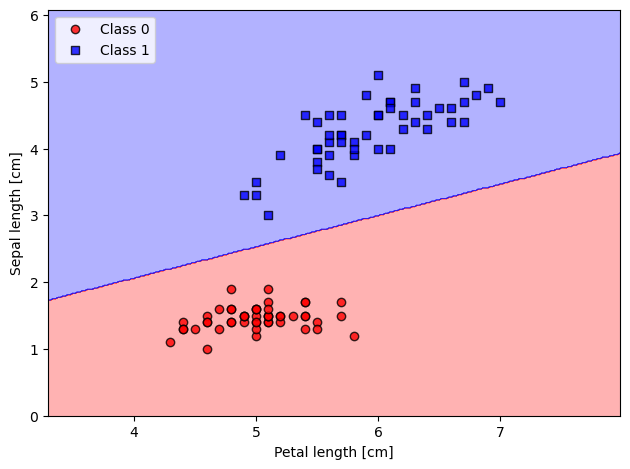

In [9]:
plot_decision_regions(X=X, y=y, classifier=lrgd)

plt.xlabel('Petal length [cm]')
plt.ylabel('Sepal length [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## EXAMPLE 2: Two classes, **all** features

We now take the same two classes from the Iris dataset, but use **all four features** (sepal length, sepal width, petal length, petal width). We won't be able to directly visualize the 4D boundary, but we can pick two features to visualize afterwards.

In [10]:
# Extract the same 100 rows, but keep all 4 features:
X_all = df.iloc[0:100, :4].values
# y remains the same: 0 (Setosa) or 1 (Versicolor).

In [11]:
# Initialize and fit the logistic regression model on all 4 features
lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_all, y);

#### Checking predictions and plotting (for two selected features only)
We can still pick any two features out of the four to see how the classification might look, even though the model uses all 4 features internally.

In [12]:
# Evaluate predictions on the training data
y_pred_all = lrgd.predict(X_all)
print("Predictions on the 4-feature set:")
print(y_pred_all)


Predictions on the 4-feature set:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [13]:
# Print the class probabilities (sigmoid outputs):
probs_all = lrgd.activation(lrgd.net_input(X_all))
print("Class Probabilities (for '1') on the 4-feature set (first 10 samples):")
print(probs_all[:10])

Class Probabilities (for '1') on the 4-feature set (first 10 samples):
[0.00098039 0.00388438 0.00185066 0.00541511 0.00081778 0.0012985
 0.00208416 0.00196604 0.00695892 0.00374131]


#### Plotting the classification using only two of the features for display
The model still uses all 4 features to decide, but we'll plot using only 2. We re-use the same code as before, but we skip using the decision region function since it expects a 2D dataset for training.

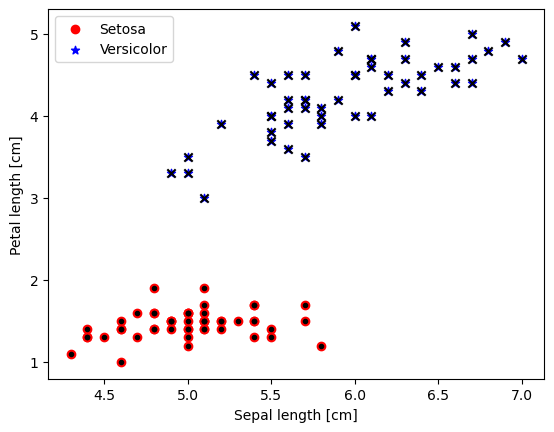

In [14]:
# Let's choose features 0 and 2 just for plotting:
ftp = [0, 2]

# Plot the original data for the same 100 samples.
plt.scatter(X_all[:50, ftp[0]], X_all[:50, ftp[1]],
            color='red', marker='o', label='Setosa')
plt.scatter(X_all[50:100, ftp[0]], X_all[50:100, ftp[1]],
            color='blue', marker='*', label='Versicolor')

# Now overlay predicted labels in black.
dict_iris = {0: '.', 1: 'x'}
for j in range(100):
    plt.scatter(X_all[j, ftp[0]], X_all[j, ftp[1]],
                color='black', marker=dict_iris[y_pred_all[j]])

dict_features = {0: 'Sepal length [cm]',
                 1: 'Sepal width [cm]',
                 2: 'Petal length [cm]',
                 3: 'Petal width [cm]'}

plt.xlabel(dict_features[ftp[0]])
plt.ylabel(dict_features[ftp[1]])
plt.legend(loc='upper left')
plt.show()

## EXAMPLE 3: One-vs-All for three classes

Next, we extend the logistic regression approach to more than 2 classes. A simple approach is the *One-vs-All* (OvA) scheme: we train one classifier for each class, labeling samples of that class as '1' and the rest as '0'. Then, we take the class that has the highest probability as the final prediction.

In [15]:
# We'll now use the entire 150-sample Iris dataset for all 3 classes.
# 0 -> Iris-setosa, 1 -> Iris-versicolor, 2 -> Iris-virginica


In [16]:
# Convert the string labels to integer labels 0, 1, or 2
y_all = df.iloc[:, 4].values
y_all = np.where(y_all == 'Iris-setosa', 0, y_all)
y_all = np.where(y_all == 'Iris-versicolor', 1, y_all)
y_all = np.where(y_all == 'Iris-virginica', 2, y_all)

# Extract all 4 features now.
X_all2 = df.iloc[:, :4].values

print("Class labels:", np.unique(y_all))

Class labels: [0 1 2]


#### One-vs-All approach
We will create three separate binary logistic regression models, each trained to detect one class vs. all others (e.g., Class=0 vs. not-0, Class=1 vs. not-1, Class=2 vs. not-2). Then, we store the probabilities and pick the class with the highest probability for each sample.

In [17]:
probabilities = np.zeros((X_all2.shape[0], 3))

for k in range(3):
    # Build a binary label for class k
    y_k = np.where(y_all == k, 1, 0)

    # Create and fit a logistic regression model
    lrgd_k = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
    lrgd_k.fit(X_all2, y_k)

    # Store the predicted probabilities for class k
    probabilities[:, k] = lrgd_k.activation(lrgd_k.net_input(X_all2))


Now, each row of `probabilities` has 3 values, one for each class's logistic regression model. Note that in practice, these do not sum to 1, since each classifier is doing a separate binary detection. 

To get the final predicted class, we take the `argmax` across the 3 columns.

In [18]:
print("Probabilities array shape:", probabilities.shape)
print("Probabilities (first 5 samples):\n", probabilities[:5])

Probabilities array shape: (150, 3)
Probabilities (first 5 samples):
 [[9.98426397e-01 1.98703267e-01 6.53709960e-10]
 [9.94462530e-01 5.89366925e-01 5.36594703e-09]
 [9.97161836e-01 2.62778257e-01 3.49954053e-09]
 [9.92306781e-01 3.71812120e-01 1.60275735e-08]
 [9.98656379e-01 1.16887028e-01 6.63423575e-10]]


In [19]:
# For demonstration, let's check the probabilities for some rows and the corresponding argmax
some_rows = [100, 40, 120, 50, 0]
print("Probabilities for rows", some_rows, ":\n", probabilities[some_rows, :])

predicted_classes = np.argmax(probabilities[some_rows, :], axis=1)
print("Predicted classes for these rows:", predicted_classes)

Probabilities for rows [100, 40, 120, 50, 0] :
 [[1.74295075e-06 1.17229795e-01 9.99458441e-01]
 [9.98609706e-01 1.02336026e-01 9.03436548e-10]
 [8.36688281e-06 5.17400091e-01 9.74423152e-01]
 [1.34792269e-03 9.46569882e-01 4.22117143e-03]
 [9.98426397e-01 1.98703267e-01 6.53709960e-10]]
Predicted classes for these rows: [2 0 2 1 0]


In [20]:
# Finally, the predicted class across *all* samples:
predicted_all = np.argmax(probabilities, axis=1)
print("Full predicted classes (first 25 shown):\n", predicted_all[:25])

Full predicted classes (first 25 shown):
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Note that if we wanted a valid set of 'class probabilities' that sum to 1, we might consider *softmax regression*, but the OvA approach here simply uses separate binary logistic regressions for each class.

### Example: Another Minimal Implementation (for reference)
The following minimal class `OneModel` is conceptually the same logistic regression approach but coded more succinctly, purely for demonstration.

In [21]:
class OneModel:
    """A minimal logistic regression model using gradient descent."""

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit the model parameters to the given training data."""
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = 0.0
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)

            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * errors.mean()

            # Cross-entropy loss
            output_clipped = np.clip(output, 1e-10, 1 - 1e-10)
            loss = -y.dot(np.log(output_clipped)) - (1 - y).dot(np.log(1 - output_clipped))
            loss /= X.shape[0]
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        z_clipped = np.clip(z, -250, 250)
        return 1. / (1. + np.exp(-z_clipped))

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

### Multinomial Logistic Regression

For multi-class classification with $K$ classes, we use a one-hot encoding for the labels. Let $y_{ik}$ be 1 if sample $i$ belongs to class $k$ and 0 otherwise. For each class $k$, we have a corresponding linear predictor:
$$
z_{ik} = \mathbf{w}_k^\top \mathbf{x}_i + b_k.
$$

The softmax function is then used to convert these scores into probabilities:
$$
\hat{p}_{ik} = \frac{\exp(z_{ik})}{\sum_{j=1}^{K} \exp(z_{ij})}.
$$

The multinomial (or categorical) cross-entropy loss is:
$$
\mathcal{L}(\{\mathbf{w}_k, b_k\}) = - \sum_{i=1}^{n} \sum_{k=1}^{K} y_{ik} \log(\hat{p}_{ik}) = - \sum_{i=1}^{n} \sum_{k=1}^{K} y_{ik} \log\left(\frac{\exp(\mathbf{w}_k^\top \mathbf{x}_i + b_k)}{\sum_{j=1}^{K} \exp(\mathbf{w}_j^\top \mathbf{x}_i + b_j)}\right).
$$

In [22]:
# Import necessary libraries
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Initialize and train the multinomial logistic regression model.
# The 'lbfgs' solver supports multinomial loss; you can also experiment with others like 'saga'.
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=iris.target_names)

print("Accuracy:", accuracy)


Accuracy: 0.9666666666666667


/Users/vegard/opt/anaconda3/envs/gra4160/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
